# <span style="color:#336699">Introduction to Data Science - CAP 394 [<img src="./img/icone_cap394.svg" alt="CAP394 - Introduction to Data Science" style="height:120px;" align="right">](http://www.lac.inpe.br/~rafael.santos/cap394.html)</span>


<hr style="border:2px solid #0077b9;">

   
<h1> <p align="right"> Exploratory Analysis of Meteorological Radar Dataset </p> </h1>
   
<p align='center'> Project for course  Introduction to Data Science - CAP 394</p>

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

#### Student: 
* Helvecio Leal Neto



## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Preprocessing
     - [x] Cluster detection algorithm
     - [x] Relational Directions
     - [x] Create Data Functions
     - [x] Visualization Radar image
     - [x] Statistics and Results
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>
  
 <hr style="border:1px solid #0077b9;">

<a id='about'></a>
## About

<p align="justify"> <br>
This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis of radar data, gathering raw data, processing it and understanding the dynamics of cloud location from its center of mass, as well as counting the number of clusters per period.
At the end of the exploratory process it will be possible to estimate the behavior of the clouds and relate their geographical location as well as correlate average precipitation rates per hour.

<hr style="border:1px solid #0077b9;">

<a id='the_data'></a>
## The Data

<p align="justify"><br>
The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals. The dataset provides rain data over 2.5km from S-Band Radar located in lat: -3.148556, lon: -59.992000. Data dimensionality consists of a two-dimensional (241x241) matrix containing rain rate values, the Radar Radius range is approximately 240 km, covering an area of 1,500 km² over the state of Amazonas (Brazil).
<p align="justify"><br>
Overview:

"S-band radar volumes from Manaus, Brazil were shared by SIPAM for the time period beginning in January 2014 to December 2015 partially coinciding with the GOAmazon field campaign. The corrected radar reflectivity from each volume were interpolated to a fixed grid and the rainfall products were generated. A single Z-R relation (Z=174.8R^1.56) was created using 2014 wet-season impact disdrometer data and applied to the 2.5 km SIPAM Manaus S-Band CAPPI data to generate rain rates for each radar volume. This is version 2.0a of the dataset, which benefits from improved quality control procedures to remove non-meteorological data. " Schumacher</p>


https://www.arm.gov/research/campaigns/amf2014goamazon <br>

* Courtney Schumacher	S-band Radar - Rain Rates

<img src="img/SIPAM.png" align="center" alt="Drawing" style="width: 600px;">


[Figure 01: REDEMET - Radar Manaus](https://www.redemet.aer.mil.br/?i=produtos&p=radares-meteorologicos)
<hr style="border:1px solid #0077b9;">

## Questions about the data

1. How can I do the data acquisition?
2. How can I open the data?
3. What are the functions to view the data content?
4. How to format data efficiently?
5. Which precipitation rate intensity thresholds are interesting?
6. What techniques for clustering can be applied to the dataset?
7. How to convert values in Rain Rate Fall to DBz?
8. What geographic applications can be associated with data?
9. How to organize and process data efficiently?
10. How to use a library to plot radar images?
11. How many clusters per hour and month are in the dataset?
12. What is the accumulated rain fall present in the data?
13. What are the directional relationships of each cluster?

<hr style="border:1px solid #0077b9;">

<a id='reading_data'></a>
## 1. Basic read process

### 1.1 Reading the metadata file

In [1]:
import os
import xarray as xr

In [2]:
### open files day 2014 / 01 / 03
day = 20140103

### path contains dataset
path = 'data/radar/'

#read first file to extract static variable values
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[0])
    
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
xds

<xarray.Dataset>
Dimensions:     (x0: 241, y0: 241)
Dimensions without coordinates: x0, y0
Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 ...
    lon0        (y0, x0) float32 ...
    rain_rate   (y0, x0) float32 ...
Attributes:
    description:  SIPAM Manaus S-Band Gridded Rain Rates
    source:       SIPAM Manaus S-Band Radar
    institution:  SIPAM/Texas A&M University
    comment:      v2.0a; Created at Texas A&M University (cschu@tamu.edu)
    references:   http://atmo.tamu.edu/goamazon-sband-radar
    created:      Tue Sep  5 14:22:16 2017\n

In [3]:
# settingup the variables
rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

print('Unit of Rain Rate: ',runit)

Unit of Rain Rate:  mm/hr


### 1.2 Read data function

In [4]:
import numpy as np

def readData(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # pixel size (in meters)
    dx = 1000.
    dy = 1000.

    downsizeby = 1    

    # Compute grid dimensions and grid coordinates after resampling
    dx2, dy2 = dx*downsizeby, dy*downsizeby
    nx2, ny2 = int(nx/downsizeby), int(ny/downsizeby)

    X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

    # Define container
    frames = np.zeros( (interval, nx2, ny2 ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

#### The values loaded for frames correspond to the number of daily observations, and their respective matrices with rainfall rate values.

In [5]:
frames = readData(day)
print('The frames from dataset:data (times,x,y) -> ',frames.shape)

The frames from dataset:data (times,x,y) ->  (2, 241, 241)


#### Plot simple example for visualization

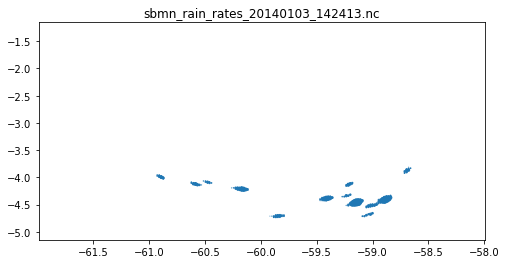

In [7]:
import matplotlib.pyplot as plt
## Plot simple figure from dataset

figtime = 0
filename = sorted(os.listdir(path+str(day)))[figtime]

plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(lon,lat,frames[figtime])
plt.show();

### 1.3 Pre-Processing Function

This function is used to store matrix "x" and "y" coordinates, that have values diffent than "NaN" and greater than the fixed Threshold for each cloud, the values correspond to the characteristic threshold intensity of each point.

<img src="img/dbz_scale.png" align="center" alt="Drawing" style="width: 800px;">

In [8]:
import pandas as pd

def pre_processing(time1):
    
    ## thereshold value to track
    threshold = 21.8
    
    te = pd.DataFrame()    
    dx ,dy = [],[]
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(time1[i][j]) and time1[i][j] > threshold:
                dx.append(i)
                dy.append(j)

    dim = len(dx)
    
    # Check dimension
    if dim > 4:   
        for x in range(dim):
            dx.append(np.float32('nan'))
            dy.append(np.float32('nan'))

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        pt = pd.DataFrame(columns=['x1','y1'])
    
        for x in range(dim):
            matrix[x] = (dx[x], dy[x])
            pt['x1'] = matrix[:,0]
            pt['y1'] = matrix[:,1]

        te = pt[['x1','y1']]
        
    return te

Pre_processing function output with values "x" and "y".

In [9]:
pdata = pre_processing(frames[0])
pdata.head()

,x1,y1
0,46.0,166.0
1,47.0,166.0
2,47.0,167.0
3,47.0,168.0
4,48.0,167.0


### 1.4 Clustering Process with MeanShift

The purpose of the Mean-Shift clustering technique is to infer the average of clusters by their related density function, where an area calculation is made where the density values are higher and at this point a central point called centroid is measured. The process is performed recursively and is only terminated when the inference value is equal to the previous one.

<img src="img/ms_2d_bw_2.gif" align="left" alt="Drawing" style="width: 400px;">

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def clust(time1):
    
    te = time1
    
    if len(te) < 2:
        return None
    
    bandwidth = estimate_bandwidth(te, quantile=0.9)
    
    if bandwidth > 0:
        ms = MeanShift(bandwidth=5, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)
    else:
        ms = MeanShift(bandwidth=10, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels
        
#     colors = 10*['r.','g.','b.','c.','k.','y.','m.']
#     for i in range(len(te)):
#         plt.plot(te['x1'][i], te['y1'][i], colors[labels[i]], markersize = 10)
#         plt.title('Estimated number of clusters: %d' % n_clusters_)
        
#     for i, txt in enumerate(range(n_clusters_)):
#         plt.annotate(txt,(cluster_centers[i,0],cluster_centers[i,1]),textcoords="offset points",xytext=(0,10),ha='center')
#     te['cluster']=labels
    
#     plt.scatter(cluster_centers[:,0], cluster_centers[:,1],
#                marker = 'x', s=150, linewidths=10, zorder=10)
    
    return te

,x1,y1,cluster
0,46.0,166.0,0
1,47.0,166.0,0
2,47.0,167.0,0
3,47.0,168.0,0
4,48.0,167.0,0


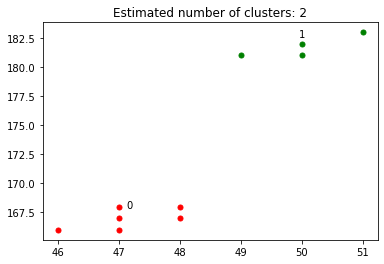

In [11]:
clusters = clust(pdata)
clusters.head()

### 1.5 Direction Relations

To define direction relationships between the central points of each cloud and the radar, we use the directional relationship between the points. This approach has as its principle to relate the coordinates of the points and to verify the location between a reference point and a point to be measured. According (Papadias & Sellis, 1994), there are nine possible ways to place a primary point relative to a reference point in the plane, and thus nine disjoint relationships between coordinate pairs that provide complete object coverage.

<img src="img/direction_relations.png" align="center" alt="Drawing" style="width: 800px;">

In [13]:
def tRelation(p,q):

    north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
    restricted_north =  p[1] == q[1] and  p[0] >  q[0]
    north_east       =  p[1] >  q[1] and  p[0] >  q[0]
    restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
    same_position    =  p[1] == q[1] and  p[0] == q[0]
    restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
    south_west       =  p[1] <  q[1] and  p[0] <  q[0]
    restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
    south_est        =  p[1] >  q[1] and  p[0] <  q[0]

    if north_west == True:
        return ('NW')
    if restricted_north == True:
        return ('RN')
    if north_east == True:
        return ('NE')
    if restricted_west == True:
        return ('RW')
    if same_position == True:
        return('SP')
    if restricted_east == True:
        return ('RE')
    if south_west == True:
        return ('SW')
    if restricted_south == True:
        return ('RS')
    if south_est == True:
        return ('SE')

In [14]:
x1,y1 = -1.9451030492782593,-61.034568786621094      # p(POINT)
r1,r2 = -3.148556, -59.992000                        # q(RADAR)
p = (x1,y1)                                    #PONTO
q = (r1,r2)                                    #RADAR

print('Point p is ',tRelation(p,q),' of the radar.')

Point p is  NW  of the radar.


### 1.6 Create Data Process

In [15]:
def createData(day,time,clusters,frames):

    ##Static Radar Coordinates Value for Topological relation
    radar = (-3.148556, -59.992000)

    if isinstance(clusters,pd.DataFrame):

        FAM1 = pd.DataFrame(columns=['YEAR','MONTH','DAY','HOUR','MINUTE',
                                     'N_Cluster','ID_CLUS','LAT','LON','IND_X','IND_Y',
                                     'T_RELATION','RAIN_FALL','DBz'])

        LAT_ = (lat[clusters['x1'].astype(int),clusters['y1'].astype(int)])
        LON_ = (lon[clusters['x1'].astype(int),clusters['y1'].astype(int)])

        rfall = []
        rlation = []
        
        for i,row in clusters.iterrows():
            rfall.append(frames[row['x1'].astype(int)][row['y1'].astype(int)])
            r = tRelation((LAT_[i],LON_[i]),radar)
            rlation.append(r)
            

        FAM1['IND_X'], FAM1['IND_Y'] = clusters['x1'],clusters['y1']
        FAM1['LAT'],FAM1['LON'] = LAT_,LON_
        FAM1['N_Cluster'] = len(clusters['cluster'].unique())
        FAM1['ID_CLUS'] = clusters['cluster']
        FAM1['RAIN_FALL'] = rfall
        FAM1['T_RELATION'] = rlation
        FAM1['DBz'] =  10 * np.log10(200*FAM1['RAIN_FALL']**1.6)
        FAM1['YEAR'] = str(sorted(os.listdir(path+str(day)))[time])[16:20]
        FAM1['MONTH'] = str(sorted(os.listdir(path+str(day)))[time])[20:22]
        FAM1['DAY'] = str(sorted(os.listdir(path+str(day)))[time])[22:24]
        FAM1['HOUR'] = str(sorted(os.listdir(path+str(day)))[time])[25:27]
        FAM1['MINUTE'] = str(sorted(os.listdir(path+str(day)))[time])[27:29]
       
    else:
        return None

    return FAM1

In [16]:
cdata = createData(day,0,clusters,frames[0])
cdata.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
0,2014,01,03,14,24,2,0,-4.478432,-59.163094,46.0,166.0,SE,30.003651,46.645086
1,2014,01,03,14,24,2,0,-4.460466,-59.163113,47.0,166.0,SE,27.854378,46.128595
2,2014,01,03,14,24,2,0,-4.460450,-59.145092,47.0,167.0,SE,49.536560,50.129113
3,2014,01,03,14,24,2,0,-4.460433,-59.127075,47.0,168.0,SE,37.524036,48.199253
4,2014,01,03,14,24,2,0,-4.442484,-59.145111,48.0,167.0,SE,24.410774,45.211605


### 1.7 Extract Centroid by Max RAIN_FALL value

In [17]:
def centroidData(clus):
    if isinstance(clus,pd.DataFrame):
        centroid = pd.DataFrame()
        for i in range(clus['N_Cluster'].max()):
            ct = clus.loc[clus['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid = centroid.append(ct)
    else:
        return None
    return centroid

In [18]:
centroidData(cdata).head()

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
2,2014,01,03,14,24,2,0,-4.460450,-59.145092,47.0,167.0,SE,49.536560,50.129113
8,2014,01,03,14,24,2,1,-4.406266,-58.874878,50.0,182.0,SE,33.433567,47.397223


### 1.8 Pre-processing Data

In [19]:
def run(day):
    data = readData(day)
    dados = pd.DataFrame()
    
    for i in range(len(data)):
        proc = pre_processing(data[i]) 
        cluster = clust(proc)
             
        if isinstance(cluster,pd.DataFrame):
            clt = createData(day,i,cluster,data[i])
            clt2 = centroidData(clt)
            dados = dados.append(clt2)
        else:
            pass     
    dados.to_csv('output/Moderate_Centroid_OUTPUT_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')
    pass

###  1.9 Run process per Day

In [20]:
day = 20140103
runner = run(day)

### 1.9.1 Plot Data

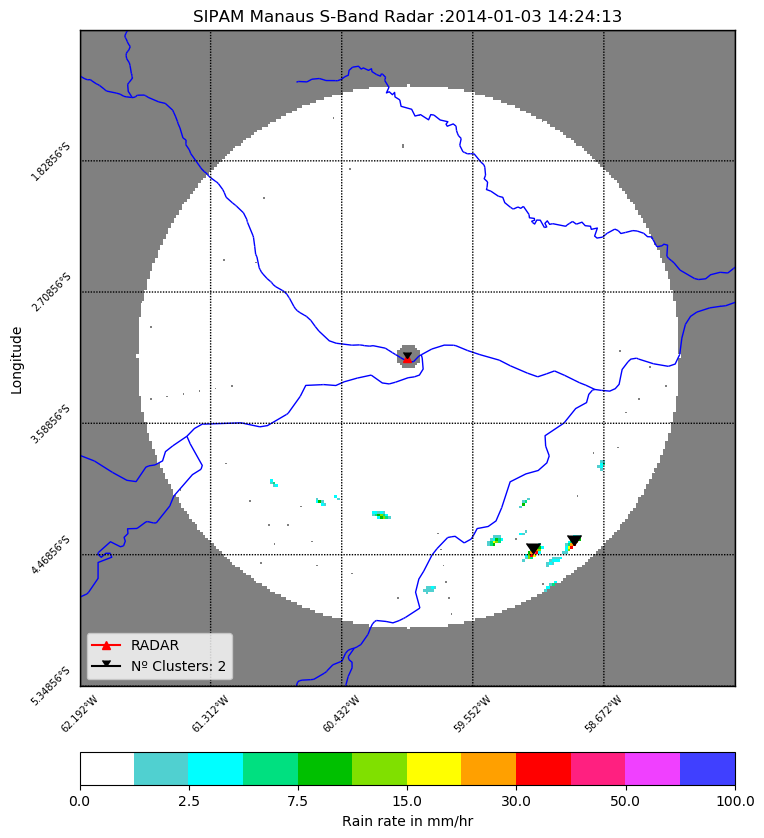

In [73]:
day = 20140103
plot(0,day)

In [72]:
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
from matplotlib import markers

def plot(frame,day):

    data = readData(day)
    proc = pre_processing(data[frame])
    clt = clust(proc)

    cdata = createData(day,frame,clt,data[frame])
    centers = centroidData(cdata)

    if centers is not None:
        c_lat = centers['LAT']
        c_lon = centers['LON']
        
        centroid = []
        for i in range(centers['N_Cluster'].max()):
            ct = centers.loc[centers['ID_CLUS'] == i ]
#             ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid.append(ct) 
    else:
        centroid = ''
        
    file = path+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[frame])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)

    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain rate in ' + runit+ ''
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## PRECIPTACAO
    xi, yi = m(lon, lat)
    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

    for cent in range(len(centroid)):
        clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()
        #clat, clon, mm_f = centroid[1]['LAT'].item(),centroid[1]['LON'].item(),centroid[1]['RAIN_FALL'].item()
        t3x,t3y = m(clon, clat)
        m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
#         plt.annotate(str(mm_f)[0:5]+'mm/h', xy=(t3x,t3y),xytext=(t3x+12,t3y+12),rotation=45, size=10)

    m.plot(xm,ym, label='Nº Clusters: ' +str(len(centroid)),marker=markers.CARETDOWN, color='k')

    cs = m.pcolormesh(xi,yi,data[frame], cmap = cmap, norm = norm, ax=ax)

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.readshapefile('./img/hidro/lineaire_1km', 'hidro10km', color='b', linewidth=1)
    # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    plt.savefig('radar_image/'+ sorted(os.listdir(path+str(day)))[frame]+'.png')

    plt.show()

In [ ]:
day = 20140103
plot(0,day)

## CREATE ALL FIGS
for i in range(len(frames)):
    plot(i,day)

### 2. Statistics and Results

In [23]:
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [24]:
l = [pd.read_csv(filename) for filename in sorted(glob.glob("output/centroids/*.csv"))]
dados = pd.concat(l, axis=0, sort=False)

In [25]:
dados.head()

,Unnamed: 0,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
0,2,2014.0,1.0,3.0,14.0,24.0,2.0,0.0,-4.460450,-59.145092,47.0,167.0,SE,49.536560,50.129113
1,8,2014.0,1.0,3.0,14.0,24.0,2.0,1.0,-4.406266,-58.874878,50.0,182.0,SE,33.433567,47.397223
2,3,2014.0,1.0,3.0,14.0,36.0,4.0,0.0,-4.496414,-59.181095,45.0,165.0,SE,50.096111,50.207164
3,12,2014.0,1.0,3.0,14.0,36.0,4.0,1.0,-4.011260,-60.892487,72.0,70.0,SW,32.283249,47.153936
4,9,2014.0,1.0,3.0,14.0,36.0,4.0,2.0,-4.173181,-60.604446,63.0,86.0,SW,32.612488,47.224443


In [26]:
dados = dados.loc[:, ~dados.columns.str.contains('^Unnamed')]
data2014 = dados.loc[dados['YEAR'] == 2014]
data2015 = dados.loc[dados['YEAR'] == 2015]

tidy_data2014 = pd.DataFrame()
tidy_data2015 = pd.DataFrame()

In [27]:
data2014 = data2014[['YEAR','MONTH','DAY','HOUR','MINUTE','N_Cluster','ID_CLUS','T_RELATION','RAIN_FALL','DBz']]

data2014['YEAR'] = data2014['YEAR'].astype(int)
data2014['MONTH'] = data2014['MONTH'].astype(int)
data2014['DAY'] = data2014['DAY'].astype(int)
data2014['HOUR'] = data2014['HOUR'].astype(int)
data2014['MINUTE'] = data2014['MINUTE'].astype(int)
data2014['N_Cluster'] = data2014['N_Cluster'].astype(int)
data2014['ID_CLUS'] = data2014['ID_CLUS'].astype(int)
data2014['T_RELATION'] = data2014['T_RELATION'].astype(str)

data2014['DateTime'] = data2014.apply(lambda row: datetime(
                              row['YEAR'], row['MONTH'], row['DAY'], row['HOUR'], row['MINUTE']), axis=1)

data2014 = data2014.drop(columns=['YEAR','MONTH','DAY','HOUR','MINUTE'])
data2014 = data2014.set_index('DateTime')

In [28]:
tidy_data2014 = data2014
tidy_data2014.head()

,N_Cluster,ID_CLUS,T_RELATION,RAIN_FALL,DBz
DateTime,,,,,
2014-01-03 14:24:00,2,0,SE,49.536560,50.129113
2014-01-03 14:24:00,2,1,SE,33.433567,47.397223
2014-01-03 14:36:00,4,0,SE,50.096111,50.207164
2014-01-03 14:36:00,4,1,SW,32.283249,47.153936
2014-01-03 14:36:00,4,2,SW,32.612488,47.224443


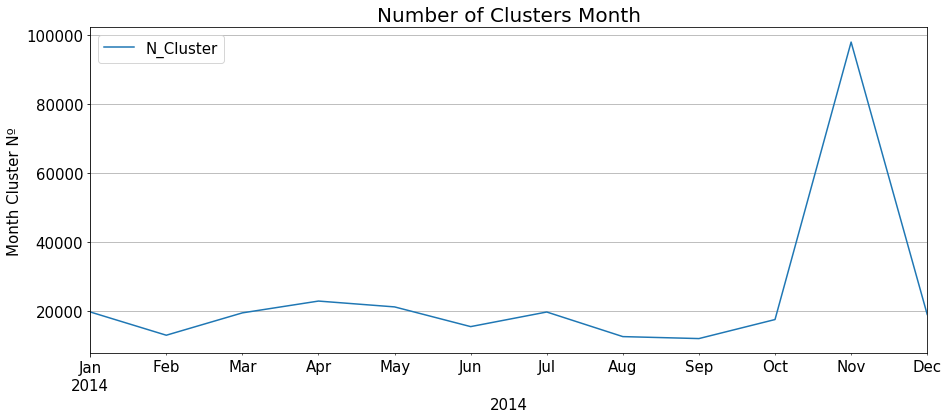

In [29]:
NCluster = tidy_data2014.resample('min').mean()
NCluster = NCluster.dropna()
NCluster = NCluster.resample('M')[['N_Cluster']].sum()

ax = NCluster.plot(figsize=(15,6), fontsize=15, grid=True)
ax.set_xlabel('2014', fontsize=15)
ax.set_ylabel('Month Cluster Nº', fontsize=15)
plt.title('Number of Clusters Month', fontsize=20)
plt.legend(fontsize='15', fancybox=True)
plt.grid(True)
plt.show()

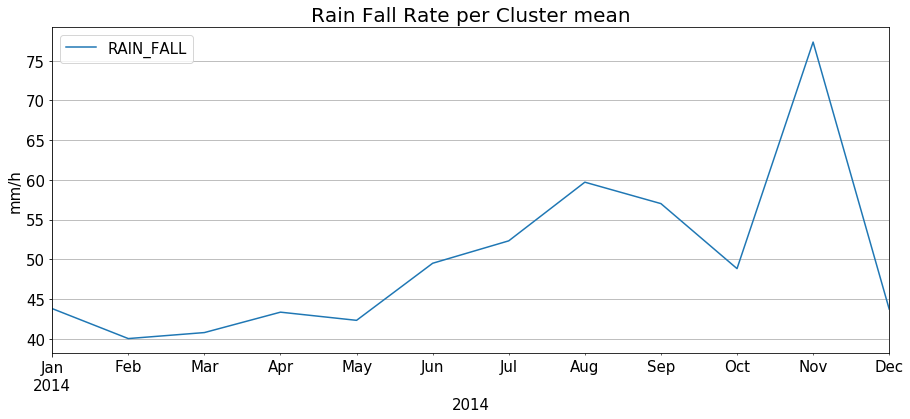

In [30]:
NRain = tidy_data2014.resample('min').mean()
NRain = NRain.dropna()
NRain = NRain.resample('M')[['RAIN_FALL']].mean()

ax = NRain.plot(figsize=(15,6), fontsize=15, grid=True)
ax.set_xlabel('2014', fontsize=15)
ax.set_ylabel('mm/h', fontsize=15)
plt.title('Rain Fall Rate per Cluster mean', fontsize=20)
plt.legend(fontsize='15', fancybox=True)
plt.grid(True)
plt.show()

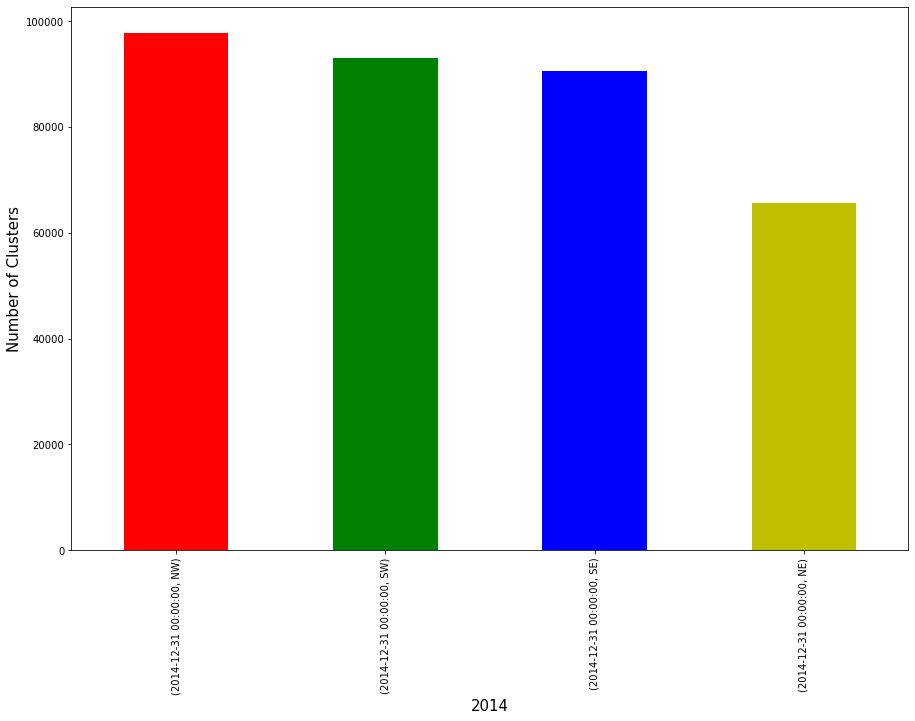

In [31]:
an2014 = tidy_data2014.resample('Y')['T_RELATION'].value_counts()
my_colors = ['r','g', 'b', 'y']
ax = an2014.plot.bar(figsize=(15,10), stacked=True, color=my_colors, legend=False)
ax.set_ylabel('Number of Clusters', fontsize=15)
ax.set_xlabel('2014', fontsize=15);

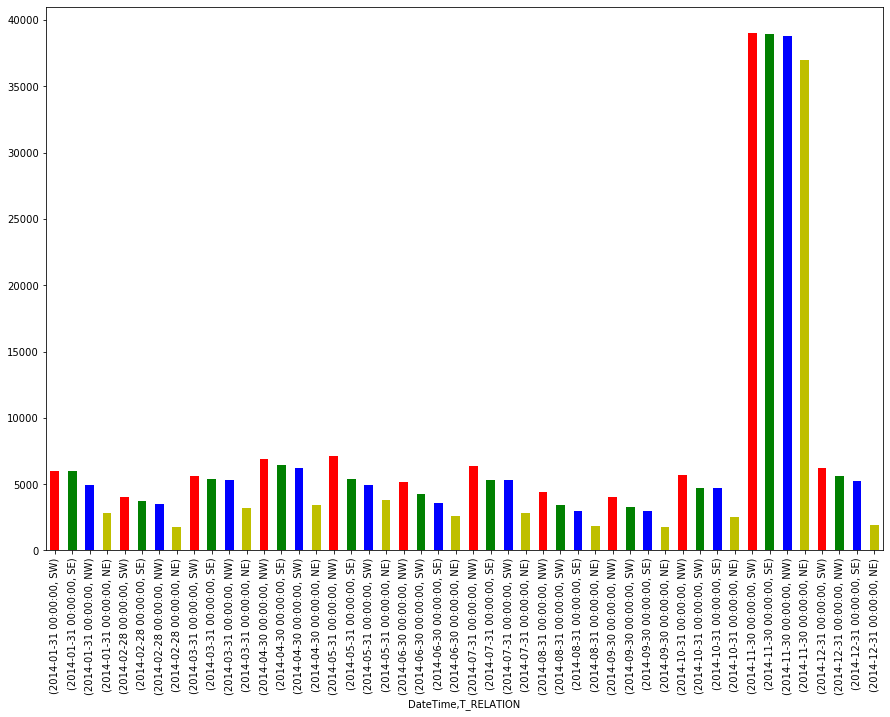

In [32]:
men2014 = tidy_data2014.resample('M')['T_RELATION'].value_counts()
my_colors = ['r','g', 'b', 'y']
men2014.plot.bar(figsize=(15,10), stacked=True,  color=my_colors, legend=False);

In [33]:
data2015 = data2015[['YEAR','MONTH','DAY','HOUR','MINUTE','N_Cluster','ID_CLUS','T_RELATION','RAIN_FALL','DBz']]

data2015['YEAR'] = data2015['YEAR'].astype(int)
data2015['MONTH'] = data2015['MONTH'].astype(int)
data2015['DAY'] = data2015['DAY'].astype(int)
data2015['HOUR'] = data2015['HOUR'].astype(int)
data2015['MINUTE'] = data2015['MINUTE'].astype(int)
data2015['N_Cluster'] = data2015['N_Cluster'].astype(int)
data2015['ID_CLUS'] = data2015['ID_CLUS'].astype(int)
data2015['T_RELATION'] = data2015['T_RELATION'].astype(str)

data2015['DateTime'] = data2015.apply(lambda row: datetime(
                              row['YEAR'], row['MONTH'], row['DAY'], row['HOUR'], row['MINUTE']), axis=1)

data2015 = data2015.drop(columns=['YEAR','MONTH','DAY','HOUR','MINUTE'])
data2015 = data2015.set_index('DateTime')

In [34]:
tidy_data2015 = data2015
tidy_data2015.head()

,N_Cluster,ID_CLUS,T_RELATION,RAIN_FALL,DBz
DateTime,,,,,
2015-01-01 15:12:00,3,0,SE,29.548908,46.538963
2015-01-01 15:12:00,3,1,SE,33.539982,47.419305
2015-01-01 15:12:00,3,2,SE,25.109665,45.407755
2015-01-01 15:24:00,1,0,SE,61.008442,51.576539
2015-01-01 15:36:00,6,0,SE,29.119005,46.437125


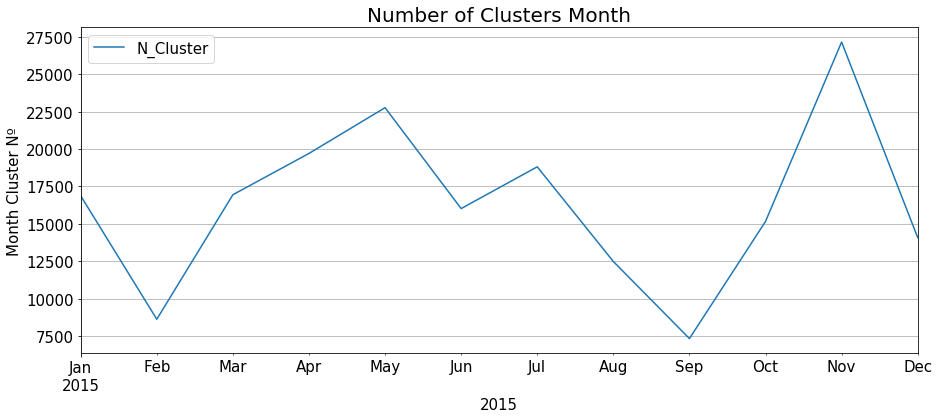

In [35]:
NCluster5 = tidy_data2015.resample('min').mean()
NCluster5 = NCluster5.dropna()
NCluster5 = NCluster5.resample('M')[['N_Cluster']].sum()

ax = NCluster5.plot(figsize=(15,6), fontsize=15, grid=True)
ax.set_xlabel('2015', fontsize=15)
ax.set_ylabel('Month Cluster Nº', fontsize=15)
plt.title('Number of Clusters Month', fontsize=20)
plt.legend(fontsize='15', fancybox=True)
plt.grid(True)
plt.show()

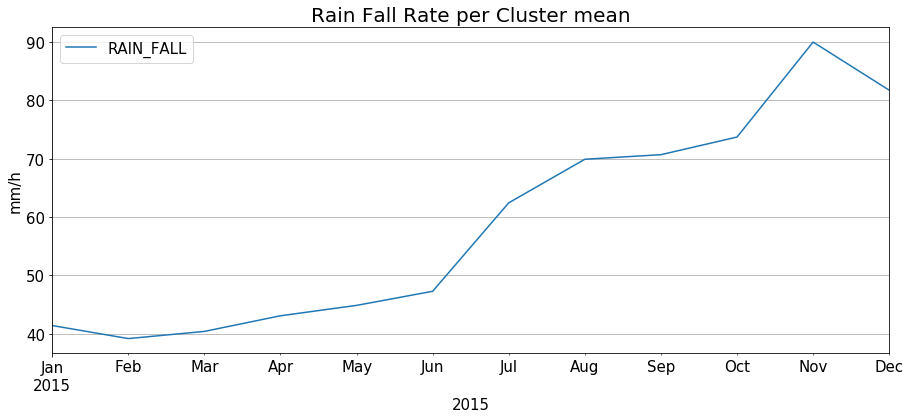

In [36]:
NRain5 = tidy_data2015.resample('min').mean()
NRain5 = NRain5.dropna()
NRain5 = NRain5.resample('M')[['RAIN_FALL']].mean()

ax = NRain5.plot(figsize=(15,6), fontsize=15, grid=True)
ax.set_xlabel('2015', fontsize=15)
ax.set_ylabel('mm/h', fontsize=15)
plt.title('Rain Fall Rate per Cluster mean', fontsize=20)
plt.legend(fontsize='15', fancybox=True)
plt.grid(True)
plt.show()

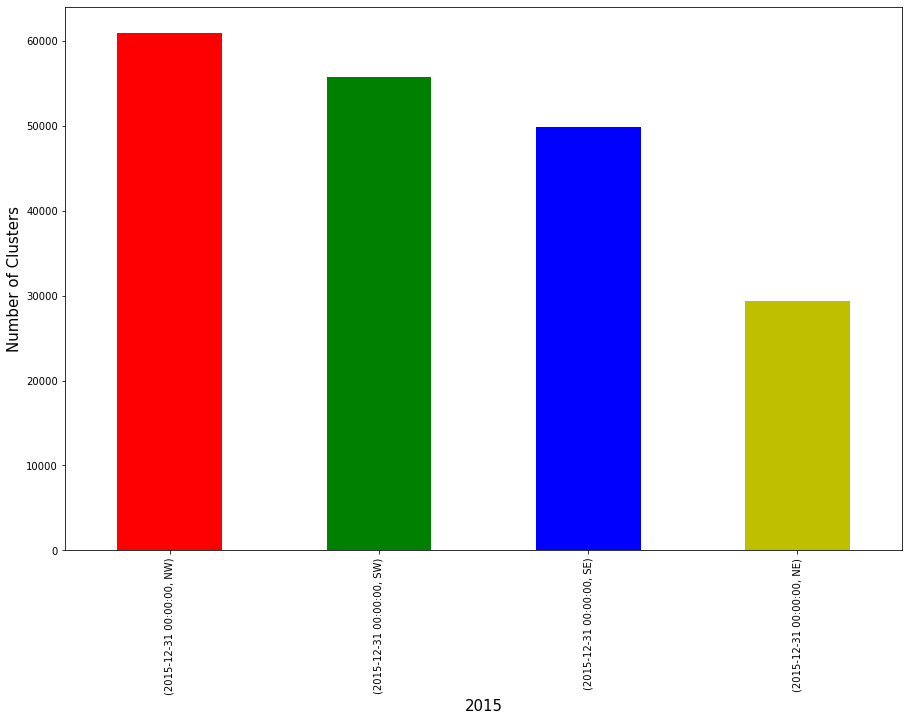

In [37]:
an2015 = tidy_data2015.resample('Y')['T_RELATION'].value_counts()
my_colors = ['r','g', 'b', 'y']
ax = an2015.plot.bar(figsize=(15,10), stacked=True, color=my_colors, legend=False)
ax.set_ylabel('Number of Clusters', fontsize=15)
ax.set_xlabel('2015', fontsize=15);

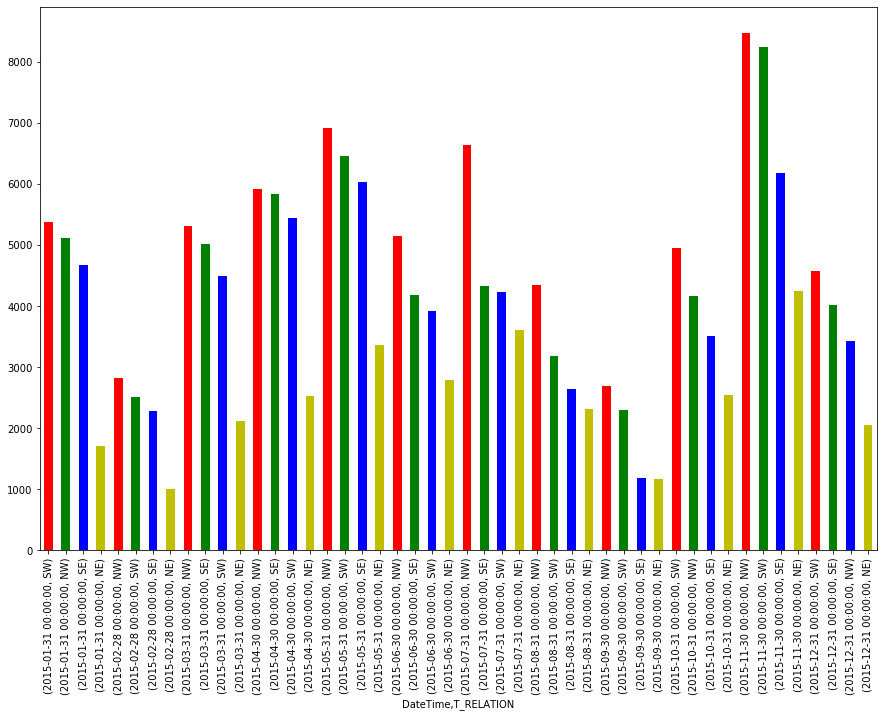

In [38]:
men2015 = tidy_data2015.resample('M')['T_RELATION'].value_counts()
my_colors = ['r','g', 'b', 'y']
men2015.plot.bar(figsize=(15,10), stacked=True,  color=my_colors, legend=False);

#### Function for create Animation (Giff File in root dir)

#### CONCLUSIONS

#### REFERENCES

* CHENG, Yizong. Mean shift, mode seeking, and clustering. IEEE transactions on pattern analysis and machine intelligence, v. 17, n. 8, p. 790-799, 1995.

* FRANK, Andrew U. Qualitative spatial reasoning: Cardinal directions as an example. International Journal of Geographical Information Science, v. 10, n. 3, p. 269-290, 1996.

* Mean Shift Clustering Overview by Matt Nedrich https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/

* The NWS NEXRAD WSR88-D Radar: https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates

* PAPADIAS, Dimitris; THEODORIDIS, Yannis. Spatial relations, minimum bounding rectangles, and spatial data structures. International Journal of Geographical Information Science, v. 11, n. 2, p. 111-138, 1997.